# 미션 11 단계별 실습 노트

이 노트는 **데이터 이해 → 간단한 EDA → 전처리 → 단어 사전 만들기 → Seq2Seq 모델 학습** 순서로 차근차근 진행합니다. 각 단계에서 왜 그렇게 하는지 충분히 설명을 달았으니 그대로 따라가면서 빈칸을 스스로 채워 보는 연습으로 활용하세요.


## 진행 순서

1. 데이터 파일 읽어 구조와 용량을 직접 확인하기
2. 문장 길이, 토큰 빈도 등을 시각화로 살펴보기 (EDA)
3. 규칙 기반 토크나이징과 단어 사전(Vocabulary) 구성하기
4. PyTorch `Dataset`/`DataLoader`로 배치 만들기
5. 간단한 Seq2Seq(Encoder-Decoder) 모델 학습 및 검증하기
6. 학습된 모델로 임의 문장 번역 테스트하기

필요에 따라 각 단계에서 파라미터를 조정하고, 궁금한 지점이 있으면 바로 코드 셀을 추가해 실험해 보세요.


In [1]:
import json
import math
import random
import re
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

plt.style.use('seaborn-v0_8')

SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

CONFIG = {
    'data_dir': Path('Part3_mission_11'),
    'train_file': '/mnt/nas/jayden_code/Codeit_Practice/Part3_mission_11/일상생활및구어체_한영_train_set.json',
    'valid_file': '/mnt/nas/jayden_code/Codeit_Practice/Part3_mission_11/일상생활및구어체_한영_valid_set.json',
    'eda_sample': 10000,
    'train_limit': 20000,
    'valid_limit': 2000,
    'min_freq': 2,
    'max_length': 40,
    'batch_size': 64,
    'embedding_dim': 128,
    'hidden_dim': 256,
    'teacher_forcing': 0.5,
    'learning_rate': 1e-3,
    'epochs': 5,
}
print("\n[CONFIG]")
for k, v in CONFIG.items():
    print(f'- {k}: {v}')


Using device: cuda

[CONFIG]
- data_dir: Part3_mission_11
- train_file: /mnt/nas/jayden_code/Codeit_Practice/Part3_mission_11/일상생활및구어체_한영_train_set.json
- valid_file: /mnt/nas/jayden_code/Codeit_Practice/Part3_mission_11/일상생활및구어체_한영_valid_set.json
- eda_sample: 10000
- train_limit: 20000
- valid_limit: 2000
- min_freq: 2
- max_length: 40
- batch_size: 64
- embedding_dim: 128
- hidden_dim: 256
- teacher_forcing: 0.5
- learning_rate: 0.001
- epochs: 5


## 1. 데이터 파일 확인하기

원본 JSON 파일은 `{"data": [{"ko": ..., "mt": ...}, ...]}` 형태입니다. 아래 함수로 파일을 읽고, EDA에 쓸 만큼만 무작위 추출합니다.


In [2]:
def load_json_pairs(path: Path, limit: int = None, seed: int = SEED) -> List[Dict[str, str]]:
    with open(path, encoding='utf-8') as f:
        data = json.load(f)['data']
    if limit is not None and limit < len(data):
        rng = random.Random(seed)
        idx = rng.sample(range(len(data)), limit)
        data = [data[i] for i in idx]
    return data


data_dir = CONFIG['data_dir']
raw_train = load_json_pairs(data_dir / CONFIG['train_file'], limit=CONFIG['eda_sample'])
print(f'EDA용 학습 데이터 샘플 수: {len(raw_train)}')
print('예시 3건:')
for sample in raw_train[:3]:
    print('KO:', sample['ko'])
    print('EN:', sample['mt'])
    print('-' * 30)


EDA용 학습 데이터 샘플 수: 10000
예시 3건:
KO: 그리고 더블 크립 제품이 하자 없는 배송 부탁드립니다.
EN: Also, please ensure that the double creep product is delivered without defects.
------------------------------
KO: 날씨 보호 테크 시스템, 특허받은 용접 모서리 및 반전된 솔기가 물을 막아줍니다.
EN: Weather protection tech system, patented welded edges and inverted seams keep water out.
------------------------------
KO: 무엇을 도와드릴까요?
EN: How may I help you?
------------------------------


## 2. 가볍게 EDA 해보기

문장 길이 분포나 자주 등장하는 단어를 보면 **최대 길이**, **정규화 방식**을 정하는 데 도움이 됩니다. 간단히 아래 내용을 확인해 봅시다.


In [3]:
def simple_tokenize(text: str, lang: str = 'ko') -> List[str]:
    text = text.strip().lower()
    if lang == 'ko':
        text = re.sub(r"[^0-9A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ!?.,'\" ]+", " ", text)
    else:
        text = re.sub(r"[^a-z0-9!?.,'\" ]+", " ", text)
    text = re.sub(r'\s+', ' ', text)
    return [tok for tok in text.split(' ') if tok]

eda_df = pd.DataFrame(raw_train)
eda_df['ko_len'] = eda_df['ko'].apply(lambda x: len(simple_tokenize(x, 'ko')))
eda_df['en_len'] = eda_df['mt'].apply(lambda x: len(simple_tokenize(x, 'en')))

print(eda_df[['ko_len', 'en_len']].describe())


             ko_len        en_len
count  10000.000000  10000.000000
mean       6.575200      9.870400
std        3.944782      5.910135
min        1.000000      1.000000
25%        4.000000      5.000000
50%        6.000000      9.000000
75%        9.000000     13.000000
max       37.000000     48.000000


In [4]:
import matplotlib.font_manager as fm, matplotlib as mpl
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
mpl.rcParams["font.family"] = "NanumGothic"
mpl.rcParams["axes.unicode_minus"] = False
print("Matplotlib 한글 폰트 설정 완료")

Matplotlib 한글 폰트 설정 완료


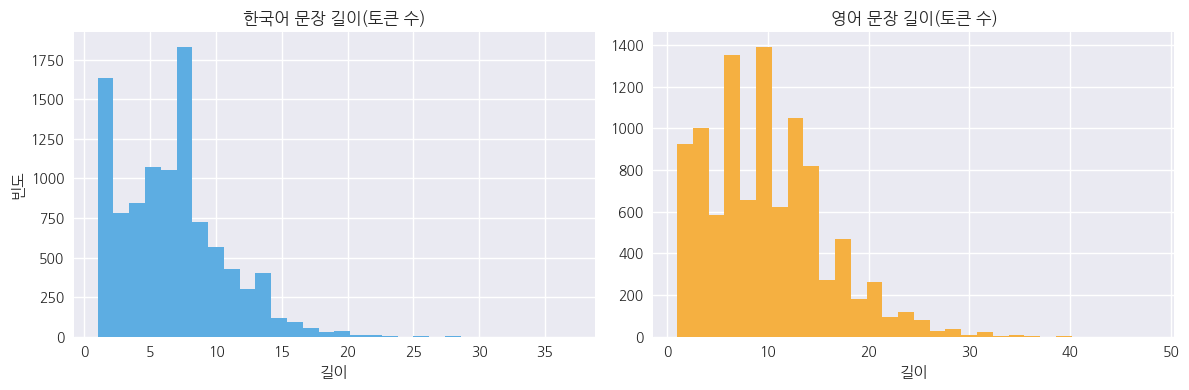

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(eda_df['ko_len'], bins=30, color='#5DADE2')
axes[0].set_title('한국어 문장 길이(토큰 수)')
axes[0].set_xlabel('길이')
axes[0].set_ylabel('빈도')

axes[1].hist(eda_df['en_len'], bins=30, color='#F5B041')
axes[1].set_title('영어 문장 길이(토큰 수)')
axes[1].set_xlabel('길이')

plt.tight_layout()
plt.show()


In [6]:
ko_counter = Counter()
en_counter = Counter()
for row in raw_train:
    ko_counter.update(simple_tokenize(row['ko'], 'ko'))
    en_counter.update(simple_tokenize(row['mt'], 'en'))

print('자주 등장하는 한국어 단어 10개:')
for word, freq in ko_counter.most_common(10):
    print(f'{word:>10} : {freq}')

print("\n자주 등장하는 영어 단어 10개:")
for word, freq in en_counter.most_common(10):
    print(f'{word:>10} : {freq}')


자주 등장하는 한국어 단어 10개:
     있습니다. : 833
         수 : 825
        저희 : 387
         이 : 319
        있는 : 270
      합니다. : 236
         더 : 231
         것 : 202
         한 : 187
        대해 : 183

자주 등장하는 영어 단어 10개:
       the : 4359
        to : 2869
         a : 2348
       you : 2336
       and : 1997
         i : 1902
        is : 1718
        of : 1654
        it : 1521
        in : 1248


> 위 EDA 결과를 보고 **MAX_LENGTH=40** 정도면 전체 문장의 대부분을 커버할 수 있겠다고 판단했습니다. 빈도 상위 단어를 보면 영어는 소문자로 통일하는 것이 적절하고, 한글도 특수문자를 많이 제거해도 무방해 보입니다.


## 3. 전처리 함수 정의하기

여기부터는 학습에 쓸 전체 데이터를 다룹니다. (너무 오래 걸리면 `train_limit`, `valid_limit`를 더 줄이세요.) 한 단계씩 함수로 나눠 두면 디버깅이 쉬워집니다.


In [7]:
def clean_and_tokenize(text: str, lang: str) -> List[str]:
    text = text.strip().lower()
    if lang == 'ko':
        text = re.sub(r"[^0-9A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ!?.,'\" ]+", " ", text)
    else:
        text = re.sub(r"[^a-z0-9!?.,'\" ]+", " ", text)
    text = re.sub(r'\s+', ' ', text)
    return [tok for tok in text.split(' ') if tok]


def build_dataset(raw_items: List[Dict[str, str]], lang_pair: Tuple[str, str]) -> List[Tuple[List[str], List[str]]]:
    src_lang, tgt_lang = lang_pair
    pairs = []
    for item in raw_items:
        src_tokens = clean_and_tokenize(item[src_lang], 'ko')
        tgt_tokens = clean_and_tokenize(item[tgt_lang], 'en')
        if src_tokens and tgt_tokens:
            pairs.append((src_tokens, tgt_tokens))
    return pairs


train_raw = load_json_pairs(data_dir / CONFIG['train_file'], limit=CONFIG['train_limit'])
valid_raw = load_json_pairs(data_dir / CONFIG['valid_file'], limit=CONFIG['valid_limit'])

train_pairs = build_dataset(train_raw, ('ko', 'mt'))
valid_pairs = build_dataset(valid_raw, ('ko', 'mt'))

print(f'train_pairs: {len(train_pairs)}, valid_pairs: {len(valid_pairs)}')
print('첫 번째 샘플:', train_pairs[0])


train_pairs: 20000, valid_pairs: 2000
첫 번째 샘플: (['그리고', '더블', '크립', '제품이', '하자', '없는', '배송', '부탁드립니다.'], ['also,', 'please', 'ensure', 'that', 'the', 'double', 'creep', 'product', 'is', 'delivered', 'without', 'defects.'])


## 4. Vocabulary 만들기

가장 많이 쓰이는 단어부터 인덱스를 부여합니다. `<pad>`, `<sos>`, `<eos>`, `<unk>`를 항상 포함하도록 했습니다.


In [8]:
class Vocabulary:
    def __init__(self, min_freq: int = 1):
        self.min_freq = min_freq
        self.special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
        self.token2idx: Dict[str, int] = {}
        self.idx2token: Dict[int, str] = {}
        for token in self.special_tokens:
            self.add_token(token)

    def add_token(self, token: str) -> None:
        if token not in self.token2idx:
            idx = len(self.token2idx)
            self.token2idx[token] = idx
            self.idx2token[idx] = token

    def build(self, sentences: List[List[str]]) -> None:
        counter = Counter()
        for sent in sentences:
            counter.update(sent)
        for token, freq in counter.items():
            if freq >= self.min_freq:
                self.add_token(token)

    def encode(self, tokens: List[str], max_len: int) -> List[int]:
        tokens = tokens[: max_len - 2]
        ids = [self.token2idx['<sos>']]
        ids += [self.token2idx.get(tok, self.token2idx['<unk>']) for tok in tokens]
        ids.append(self.token2idx['<eos>'])
        return ids

    def decode(self, ids: List[int]) -> List[str]:
        words = []
        for idx in ids:
            token = self.idx2token.get(int(idx), '<unk>')
            if token == '<eos>':
                break
            if token not in {'<pad>', '<sos>'}:
                words.append(token)
        return words

    @property
    def pad_id(self) -> int:
        return self.token2idx['<pad>']

    @property
    def size(self) -> int:
        return len(self.token2idx)


In [9]:
src_vocab = Vocabulary(min_freq=CONFIG['min_freq'])
src_vocab.build([src for src, _ in train_pairs])

tgt_vocab = Vocabulary(min_freq=CONFIG['min_freq'])
tgt_vocab.build([tgt for _, tgt in train_pairs])

print('Source vocab size:', src_vocab.size)
print('Target vocab size:', tgt_vocab.size)


Source vocab size: 12823
Target vocab size: 9091


## 5. Dataset & DataLoader 구성

토치에서 바로 읽을 수 있도록 `Dataset` 클래스를 만들어 정수 시퀀스를 반환합니다. 패딩은 `collate_fn`에서 수행합니다.


In [10]:
class TranslationDataset(Dataset):
    def __init__(self, pairs: List[Tuple[List[str], List[str]]], src_vocab: Vocabulary, tgt_vocab: Vocabulary, max_length: int):
        self.pairs = pairs
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        src_tokens, tgt_tokens = self.pairs[idx]
        src_ids = torch.tensor(self.src_vocab.encode(src_tokens, self.max_length), dtype=torch.long)
        tgt_ids = torch.tensor(self.tgt_vocab.encode(tgt_tokens, self.max_length), dtype=torch.long)
        return src_ids, tgt_ids


def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_lengths = torch.tensor([len(seq) for seq in src_batch])
    tgt_lengths = torch.tensor([len(seq) for seq in tgt_batch])
    src_padded = nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=src_vocab.pad_id)
    tgt_padded = nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=tgt_vocab.pad_id)
    decoder_inputs = tgt_padded[:, :-1]
    decoder_targets = tgt_padded[:, 1:]
    return src_padded, src_lengths, decoder_inputs, decoder_targets, tgt_lengths


train_dataset = TranslationDataset(train_pairs, src_vocab, tgt_vocab, CONFIG['max_length'])
valid_dataset = TranslationDataset(valid_pairs, src_vocab, tgt_vocab, CONFIG['max_length'])

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)

print('DataLoader 준비 완료!')


DataLoader 준비 완료!


## 6. Seq2Seq 모델 정의

Encoder와 Decoder 모두 GRU 한 층으로 구성했습니다. 입문 단계에서는 `pack_padded_sequence` 없이 **단순히 패딩된 시퀀스**를 넣고, 손실 계산 시 패딩 토큰을 무시하도록 했습니다.


In [11]:
class Encoder(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, pad_idx: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, src: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(src)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden


class Decoder(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, pad_idx: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_step: torch.Tensor, hidden: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        embedded = self.embedding(input_step.unsqueeze(1))
        output, hidden = self.gru(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, device: torch.device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src: torch.Tensor, src_lengths: torch.Tensor, decoder_inputs: torch.Tensor, teacher_forcing: float = 0.5) -> torch.Tensor:
        batch_size = src.size(0)
        target_len = decoder_inputs.size(1)
        vocab_size = self.decoder.fc_out.out_features

        _, hidden = self.encoder(src, src_lengths)
        outputs = torch.zeros(batch_size, target_len, vocab_size, device=self.device)
        input_token = decoder_inputs[:, 0]

        for t in range(target_len):
            output, hidden = self.decoder(input_token, hidden)
            outputs[:, t, :] = output
            teacher = random.random() < teacher_forcing
            if teacher and t + 1 < target_len:
                input_token = decoder_inputs[:, t + 1]
            else:
                input_token = output.argmax(dim=1)
        return outputs


## 7. 학습 및 검증 루프

손실 함수는 `CrossEntropyLoss(ignore_index=pad_id)`를 사용해 패딩 토큰은 무시합니다. 검증 시에는 teacher forcing 없이 greedy decoding을 적용해 간단한 예측 품질을 확인합니다.


In [12]:
def translate_example(model: Seq2Seq, sentence: str, max_len: int = 40) -> str:
    model.eval()
    tokens = clean_and_tokenize(sentence, 'ko')
    ids = src_vocab.encode(tokens, max_len)
    src_tensor = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
    src_lengths = torch.tensor([len(ids)])
    _, hidden = model.encoder(src_tensor, src_lengths)
    outputs = []
    input_token = torch.tensor([tgt_vocab.token2idx['<sos>']], device=device)
    for _ in range(max_len):
        output, hidden = model.decoder(input_token, hidden)
        next_id = output.argmax(dim=1)
        if next_id.item() == tgt_vocab.token2idx['<eos>']:
            break
        outputs.append(next_id.item())
        input_token = next_id
    return ' '.join(tgt_vocab.decode(outputs))


def train_model(model: Seq2Seq, train_loader: DataLoader, valid_loader: DataLoader, epochs: int = 5):
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_id)
    history = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for src, src_lengths, dec_inputs, dec_targets, _ in train_loader:
            src = src.to(device)
            dec_inputs = dec_inputs.to(device)
            dec_targets = dec_targets.to(device)

            optimizer.zero_grad()
            outputs = model(src, src_lengths, dec_inputs, teacher_forcing=CONFIG['teacher_forcing'])
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), dec_targets.reshape(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for src, src_lengths, dec_inputs, dec_targets, _ in valid_loader:
                src = src.to(device)
                dec_inputs = dec_inputs.to(device)
                dec_targets = dec_targets.to(device)
                outputs = model(src, src_lengths, dec_inputs, teacher_forcing=0.0)
                loss = criterion(outputs.reshape(-1, outputs.size(-1)), dec_targets.reshape(-1))
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)

        history.append({'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss})
        print(f'Epoch {epoch}/{epochs} | train_loss={train_loss:.3f} | valid_loss={valid_loss:.3f}')
    return history


## 8. 학습 실행

데이터 양이 많으므로 GPU 환경이 아니라면 `train_limit`, `valid_limit`, `epochs`를 줄여서 먼저 파이프라인만 확인하세요.


In [13]:
encoder = Encoder(src_vocab.size, CONFIG['embedding_dim'], CONFIG['hidden_dim'], src_vocab.pad_id)
decoder = Decoder(tgt_vocab.size, CONFIG['embedding_dim'], CONFIG['hidden_dim'], tgt_vocab.pad_id)
model = Seq2Seq(encoder, decoder, device).to(device)

training_history = train_model(model, train_loader, valid_loader, epochs=CONFIG['epochs'])
training_history


Epoch 1/5 | train_loss=6.237 | valid_loss=5.842
Epoch 2/5 | train_loss=5.636 | valid_loss=5.695
Epoch 3/5 | train_loss=5.317 | valid_loss=5.659
Epoch 4/5 | train_loss=5.071 | valid_loss=5.620
Epoch 5/5 | train_loss=4.866 | valid_loss=5.608


[{'epoch': 1,
  'train_loss': 6.237261700554016,
  'valid_loss': 5.841859340667725},
 {'epoch': 2,
  'train_loss': 5.6364312644202865,
  'valid_loss': 5.695423737168312},
 {'epoch': 3,
  'train_loss': 5.317289967887318,
  'valid_loss': 5.659234777092934},
 {'epoch': 4,
  'train_loss': 5.071347740892405,
  'valid_loss': 5.619599476456642},
 {'epoch': 5,
  'train_loss': 4.865617473285419,
  'valid_loss': 5.608177483081818}]

## 9. 번역 예시 살펴보기

학습된 모델로 임의 문장을 번역해 보면서 어떤 부분이 잘 되고 부족한지 직접 확인합니다.


In [14]:
test_sentences = [
    '오늘 저녁에 시간 있어?',
    '커피 대신 차를 마시고 싶어요.',
    '회의 자료를 영어로 다시 보내 줄 수 있어?',
]

for sent in test_sentences:
    print('KO:', sent)
    print('EN(pred):', translate_example(model, sent))
    print('-' * 30)


KO: 오늘 저녁에 시간 있어?
EN(pred): i you you the <unk>
------------------------------
KO: 커피 대신 차를 마시고 싶어요.
EN(pred): i am the <unk> of the <unk> of the <unk>
------------------------------
KO: 회의 자료를 영어로 다시 보내 줄 수 있어?
EN(pred): we can you you you can you can you the
------------------------------


## 10. 다음 단계 아이디어

- 형태소 분석기나 SentencePiece를 사용해 더 나은 토큰화 시도
- Encoder를 양방향 GRU로 바꾸기
- Decoder에 Attention을 도입해 긴 문장 처리력 향상
- 학습 로그/시각화(TensorBoard 등)를 추가해 학습 곡선을 분석
- BLEU/ROUGE 같은 정량 평가 함수 직접 구현해 비교

이 노트북을 기반으로 자신의 실험 노트와 보고서를 작성하면, **어떤 데이터를 어떤 방식으로 다뤘는지**를 명확하게 설명하기 좋습니다.


## 11. SentencePiece/형태소 기반 토큰화 (선택)

간단한 규칙 기반 토큰화로도 학습 파이프라인을 돌릴 수 있지만, 희귀 단어 처리에 한계가 있습니다. 아래 셀은 `sentencepiece`를 활용한 서브워드 모델을 학습하는 예시입니다. GPU/시간 여유가 있을 때만 실행하면 되고, 형태소 분석기를 연결하는 경우에도 이 자리에 해당 코드를 넣으면 됩니다.


In [22]:
try:
    import sentencepiece as spm
except ImportError:
    spm = None
    print("sentencepiece가 설치되어 있지 않습니다. 필요하다면 `pip install sentencepiece` 후 다시 실행하세요.")

RUN_SENTENCEPIECE = True
SPM_MODEL_PREFIX = 'spm_ko_en'
SPM_VOCAB_SIZE = 8000

if RUN_SENTENCEPIECE:
    if spm is None:
        raise ImportError('sentencepiece 패키지가 필요합니다.')
    corpus_path = data_dir / 'spm_corpus.txt'
    with open(corpus_path, 'w', encoding='utf-8') as f:
        for pair in train_raw:
            f.write(pair['ko'].replace("\n", ' ').strip() + "\n")
            f.write(pair['mt'].lower().replace("\n", ' ').strip() + "\n")
    spm.SentencePieceTrainer.Train(
        input=str(corpus_path),
        model_prefix=SPM_MODEL_PREFIX,
        vocab_size=SPM_VOCAB_SIZE,
        model_type='unigram',
        character_coverage=0.9995,
    )
    sp = spm.SentencePieceProcessor()
    sp.load(f"{SPM_MODEL_PREFIX}.model")
    print('SentencePiece 학습 완료! 예시 토큰:', sp.encode('안녕하세요 만나서 반가워요.', out_type=str)[:15])
else:
    print('SentencePiece 실험은 RUN_SENTENCEPIECE=True 로 변경 후 실행하세요.')


FileNotFoundError: [Errno 2] No such file or directory: 'Part3_mission_11/spm_corpus.txt'

## 12. BLEU/ROUGE 등 정량 평가 함수

검증 손실 외에 번역 품질을 수치로 비교하기 위해 간단한 BLEU, ROUGE-L 계산 함수를 추가합니다. 또한 학습된 모델을 빠르게 평가할 수 있도록 배치 단위 greedy decoding 헬퍼를 제공합니다.


In [16]:
def corpus_bleu(references, hypotheses, max_n: int = 4, smooth_eps: float = 1e-9):
    clipped = [0] * max_n
    totals = [0] * max_n
    ref_length = 0
    hyp_length = 0
    for ref, hyp in zip(references, hypotheses):
        ref_length += max(len(ref), 1)
        hyp_length += max(len(hyp), 1)
        for n in range(1, max_n + 1):
            ref_ngrams = Counter(tuple(ref[i:i + n]) for i in range(max(len(ref) - n + 1, 0)))
            hyp_ngrams = Counter(tuple(hyp[i:i + n]) for i in range(max(len(hyp) - n + 1, 0)))
            totals[n - 1] += sum(hyp_ngrams.values())
            for ng, count in hyp_ngrams.items():
                clipped[n - 1] += min(count, ref_ngrams.get(ng, 0))
    precisions = []
    for n in range(max_n):
        numerator = clipped[n] + smooth_eps
        denominator = totals[n] + smooth_eps
        precisions.append(numerator / denominator)
    geo_mean = math.exp(sum((1 / max_n) * math.log(p) for p in precisions))
    bp = 1.0 if hyp_length > ref_length else math.exp(1 - ref_length / max(hyp_length, 1))
    return float(bp * geo_mean)


def lcs_length(a, b):
    dp = [[0] * (len(b) + 1) for _ in range(len(a) + 1)]
    for i in range(1, len(a) + 1):
        for j in range(1, len(b) + 1):
            if a[i - 1] == b[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])
    return dp[-1][-1]


def rouge_l_score(references, hypotheses):
    scores = []
    for ref, hyp in zip(references, hypotheses):
        lcs = lcs_length(ref, hyp)
        prec = lcs / max(len(hyp), 1)
        rec = lcs / max(len(ref), 1)
        if prec + rec == 0:
            scores.append(0.0)
        else:
            scores.append((2 * prec * rec) / (prec + rec))
    return float(sum(scores) / max(len(scores), 1))


def greedy_decode_batch(model, src, src_lengths, max_len: int = 50):
    model.eval()
    batch_size = src.size(0)
    sos_id = tgt_vocab.token2idx['<sos>']
    eos_id = tgt_vocab.token2idx['<eos>']
    outputs = []
    with torch.no_grad():
        if hasattr(model.decoder, 'attention'):
            encoder_outputs, hidden = model.encoder(src, src_lengths)
            mask = (src != src_vocab.pad_id)
            input_token = torch.full((batch_size,), sos_id, dtype=torch.long, device=src.device)
            for _ in range(max_len):
                prediction, hidden, _ = model.decoder(input_token, hidden, encoder_outputs, mask)
                next_token = prediction.argmax(dim=1)
                outputs.append(next_token)
                input_token = next_token
        else:
            _, hidden = model.encoder(src, src_lengths)
            input_token = torch.full((batch_size,), sos_id, dtype=torch.long, device=src.device)
            for _ in range(max_len):
                prediction, hidden = model.decoder(input_token, hidden)
                next_token = prediction.argmax(dim=1)
                outputs.append(next_token)
                input_token = next_token
    if not outputs:
        return torch.zeros((batch_size, 0), dtype=torch.long)
    stacked = torch.stack(outputs, dim=1)
    result = []
    for row in stacked:
        tokens = []
        for idx in row.tolist():
            if idx == eos_id:
                break
            tokens.append(idx)
        result.append(tokens)
    return result


def evaluate_bleu_rouge(model, data_loader, num_batches: int = 5, max_len: int = 60):
    refs, hyps = [], []
    for i, (src, src_lengths, _, dec_targets, _) in enumerate(data_loader):
        if i >= num_batches:
            break
        src = src.to(device)
        predictions = greedy_decode_batch(model, src, src_lengths, max_len=max_len)
        for target_ids, pred_ids in zip(dec_targets, predictions):
            refs.append(tgt_vocab.decode(target_ids.tolist()))
            hyps.append(tgt_vocab.decode(pred_ids))
    bleu = corpus_bleu(refs, hyps)
    rouge = rouge_l_score(refs, hyps)
    return bleu, rouge


## 13. TensorBoard/학습 로그 기록 (옵션)

학습 과정을 시각화하려면 `SummaryWriter`를 활용해 손실과 BLEU/ROUGE를 기록할 수 있습니다. 아래 함수는 기존 학습 루프에 로깅과 간단한 metric 계산을 추가한 버전입니다.


In [17]:
try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    SummaryWriter = None
    print('TensorBoard를 사용하려면 `pip install tensorboard` 후 다시 실행하세요.')


def train_model_with_logging(model, train_loader, valid_loader, epochs: int = 5, run_name: str = 'experiment', writer=None, metrics_fn=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_id)
    history = []
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for src, src_lengths, dec_inputs, dec_targets, _ in train_loader:
            src = src.to(device)
            dec_inputs = dec_inputs.to(device)
            dec_targets = dec_targets.to(device)
            optimizer.zero_grad()
            outputs = model(src, src_lengths, dec_inputs, teacher_forcing=CONFIG['teacher_forcing'])
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), dec_targets.reshape(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for src, src_lengths, dec_inputs, dec_targets, _ in valid_loader:
                src = src.to(device)
                dec_inputs = dec_inputs.to(device)
                dec_targets = dec_targets.to(device)
                outputs = model(src, src_lengths, dec_inputs, teacher_forcing=0.0)
                loss = criterion(outputs.reshape(-1, outputs.size(-1)), dec_targets.reshape(-1))
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)

        bleu = rouge = None
        if metrics_fn is not None:
            bleu, rouge = metrics_fn(model, valid_loader)
        history.append({'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss, 'bleu': bleu, 'rouge_l': rouge})

        if writer is not None:
            writer.add_scalar(f'{run_name}/train_loss', train_loss, epoch)
            writer.add_scalar(f'{run_name}/valid_loss', valid_loss, epoch)
            if bleu is not None:
                writer.add_scalar(f'{run_name}/bleu', bleu, epoch)
            if rouge is not None:
                writer.add_scalar(f'{run_name}/rouge_l', rouge, epoch)
        print(f'[LOG] {run_name} Epoch {epoch}/{epochs} | train {train_loss:.3f} | valid {valid_loss:.3f} | BLEU {bleu if bleu is not None else 0:.3f} | ROUGE-L {rouge if rouge is not None else 0:.3f}')

    if writer is not None:
        writer.flush()
    return history

USE_TENSORBOARD = False
writer = SummaryWriter(log_dir='runs/mission11') if (USE_TENSORBOARD and SummaryWriter is not None) else None


TensorBoard를 사용하려면 `pip install tensorboard` 후 다시 실행하세요.


## 14. 양방향 Encoder + Attention Decoder

이제 Encoder를 양방향 GRU로 확장하고, Decoder에 Bahdanau Attention을 추가해 긴 문장에서도 문맥 정보를 더 잘 활용하도록 합니다. 모델 아키텍처는 아래 클래스들을 참고하세요.


In [18]:
class EncoderBiGRU(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, pad_idx: int, dropout: float = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src: torch.Tensor, lengths: torch.Tensor):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.gru(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2], hidden[-1]), dim=1))).unsqueeze(0)
        return outputs, hidden


class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim: int, dec_dim: int):
        super().__init__()
        self.attn = nn.Linear(enc_dim + dec_dim, dec_dim)
        self.v = nn.Linear(dec_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask):
        hidden = hidden[-1].unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attn_scores = self.v(energy).squeeze(-1)
        attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        return context, attn_weights


class AttnDecoderGRU(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, enc_dim: int, pad_idx: int, dropout: float = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.attention = BahdanauAttention(enc_dim, hidden_dim)
        self.gru = nn.GRU(embedding_dim + enc_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim + enc_dim + embedding_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs, mask):
        embedded = self.dropout(self.embedding(input_token)).unsqueeze(1)
        context, attn_weights = self.attention(hidden, encoder_outputs, mask)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(rnn_input, hidden)
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=2).squeeze(1))
        return prediction, hidden, attn_weights


class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder, pad_idx: int):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx

    def forward(self, src, src_lengths, decoder_inputs, teacher_forcing: float = 0.5):
        encoder_outputs, hidden = self.encoder(src, src_lengths)
        mask = (src != self.pad_idx)
        batch_size = src.size(0)
        target_len = decoder_inputs.size(1)
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, target_len, vocab_size, device=src.device)
        input_token = decoder_inputs[:, 0]
        for t in range(target_len):
            prediction, hidden, _ = self.decoder(input_token, hidden, encoder_outputs, mask)
            outputs[:, t, :] = prediction
            teacher = random.random() < teacher_forcing
            if teacher and t + 1 < target_len:
                input_token = decoder_inputs[:, t + 1]
            else:
                input_token = prediction.argmax(dim=1)
        return outputs


## 15. BiGRU + Attention 학습 실행 (옵션)

고급 모델은 연산량이 많으므로 기본 설정에서는 비활성화했습니다. GPU가 있다면 아래 플래그를 `True`로 바꿔 학습해 보세요. TensorBoard 로깅과 BLEU/ROUGE 계산도 함께 활용할 수 있습니다.


In [19]:
RUN_BIGRU_ATTENTION = False
attn_model = None
attn_history = []

if RUN_BIGRU_ATTENTION:
    encoder_bigru = EncoderBiGRU(
        vocab_size=src_vocab.size,
        embedding_dim=CONFIG['embedding_dim'],
        hidden_dim=CONFIG['hidden_dim'],
        pad_idx=src_vocab.pad_id,
        dropout=0.2,
    )
    decoder_attn = AttnDecoderGRU(
        vocab_size=tgt_vocab.size,
        embedding_dim=CONFIG['embedding_dim'],
        hidden_dim=CONFIG['hidden_dim'],
        enc_dim=CONFIG['hidden_dim'] * 2,
        pad_idx=tgt_vocab.pad_id,
        dropout=0.2,
    )
    attn_model = Seq2SeqAttn(encoder_bigru.to(device), decoder_attn.to(device), src_vocab.pad_id).to(device)
    attn_history = train_model_with_logging(
        attn_model,
        train_loader,
        valid_loader,
        epochs=CONFIG['epochs'],
        run_name='bigru_attention',
        writer=writer,
        metrics_fn=lambda m, loader: evaluate_bleu_rouge(m, loader, num_batches=3),
    )
else:
    print('BiGRU + Attention 학습은 생략되었습니다. RUN_BIGRU_ATTENTION=True 로 변경하여 실행하세요.')


BiGRU + Attention 학습은 생략되었습니다. RUN_BIGRU_ATTENTION=True 로 변경하여 실행하세요.


## 16. 모델 성능 요약

아래 셀은 현재 학습된 모델(기본 Seq2Seq, BiGRU+Attention 등)에 대해 BLEU/ROUGE 지표를 계산해 줍니다. 실험을 진행할 때마다 값을 기록해 두면 보고서에 바로 활용할 수 있습니다.


In [20]:
if 'model' in globals():
    bleu_base, rouge_base = evaluate_bleu_rouge(model, valid_loader, num_batches=5)
    print(f'기본 Seq2Seq | BLEU: {bleu_base:.3f} | ROUGE-L: {rouge_base:.3f}')
else:
    print('기본 Seq2Seq 모델이 학습되지 않았습니다.')

if attn_model is not None:
    bleu_attn, rouge_attn = evaluate_bleu_rouge(attn_model, valid_loader, num_batches=5)
    print(f'BiGRU+Attention | BLEU: {bleu_attn:.3f} | ROUGE-L: {rouge_attn:.3f}')
else:
    print('BiGRU+Attention 모델은 아직 학습되지 않았습니다.')


기본 Seq2Seq | BLEU: 0.027 | ROUGE-L: 0.245
BiGRU+Attention 모델은 아직 학습되지 않았습니다.


## 마무리 노트

- **EDA/전처리 → 기본 모델 → 고급 실험**의 순서를 한 노트에서 유지했으므로, 실험기를 제출할 때도 어떤 과정을 거쳤는지 명확하게 설명할 수 있습니다.
- 학습 데이터 수(`train_limit`), SentencePiece/형태소 토큰화, BiGRU/Attention, TensorBoard 로깅, BLEU/ROUGE 평가를 조합해가며 여러 실험 로그를 남겨 보세요.
- GPU 자원이 부족하면 먼저 소규모 데이터로 파이프라인을 검증한 뒤, 설정을 늘려가며 결과를 갱신하면 됩니다.
